In [2]:

import pandas as pd

# SVR-only: preprocessing, log-feature, target log-transform, CV + grid search, plots
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np, seaborn as sns, matplotlib.pyplot as plt

import eda
import present_value

In [53]:
pv = present_value.PresentValue()
anual_increment = pv.fetch_salary_increase_per_year()
filename = "../data/raw/BASE DE DATOS PRESUPUESTOS.xlsx"
preproccesing = eda.EDA(filename)
df = preproccesing.create_dataset(pv.present_value_costs)

c:\Code\practicum\src\eda.py:135: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  w = (df[cols] / totals).fillna(0)


In [55]:
def remove_outliers(df, target: str) -> pd.DataFrame:
    q1, q3 = df[target].quantile(0.05), df[target].quantile(0.95)
    iqr = q3 - q1
    x_clean = (df[target] >= q1 - 1.5*iqr) & (df[target] <= q3 + 1.5*iqr) & (df[target] != 0)
    
    df_clean = df[x_clean]
    return df_clean

In [56]:
def train_model(df_clean, predictor_name, hue_name, target_name):
    X = df_clean[[predictor_name, hue_name]].copy()
    X[predictor_name + ' LOG'] = np.log1p(X[predictor_name])
    y = df_clean[target_name].astype(float)

    pre = ColumnTransformer([
        ('num', StandardScaler(), [predictor_name, predictor_name + ' LOG']),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), [hue_name])
    ])

    svr = SVR(kernel='rbf')
    pipe = Pipeline([('pre', pre), ('svr', svr)])
    model = TransformedTargetRegressor(regressor=pipe, func=np.log1p, inverse_func=np.expm1)

    param_grid = {
        'regressor__svr__C': [10, 100, 300, 1000],
        'regressor__svr__epsilon': [0.1, 0.3, 0.5, 1.0],
        'regressor__svr__gamma': ['scale', 'auto', 0.1, 0.01],
    }

    Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.1, random_state=1982)
    gs = GridSearchCV(model, param_grid, scoring='neg_root_mean_squared_error', cv=5, n_jobs=-1, refit=True)
    gs.fit(Xtr, ytr)

    yp = gs.predict(Xte)
    mae = mean_absolute_error(yte, yp)
    rmse = mean_squared_error(yte, yp)
    r2 = r2_score(yte, yp)
    mape = np.mean(np.abs((yte - yp) / yte.replace(0, np.nan))) * 100

    print('Best params:', gs.best_params_)
    print({'Test_R2': r2, 'Test_MAE': mae, 'Test_RMSE': rmse, 'Test_MAPE%': float(mape)})

    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(1, 2, figsize=(12,5))
    ax[0].scatter(yte, yp, alpha=0.6); lim = [yte.min(), yte.max()]
    ax[0].plot(lim, lim, 'r--'); ax[0].set_title('Actual vs Pred'); ax[0].set_xlabel('Actual'); ax[0].set_ylabel('Predicted')
    sns.histplot(yte - yp, kde=True, ax=ax[1], color='slateblue'); ax[1].set_title('Residuals')
    plt.tight_layout(); plt.show()
    
    return Xte, yte, yp 
    

*********2.2 TRAZADO Y DISEÑO GEOMÉTRICO*********


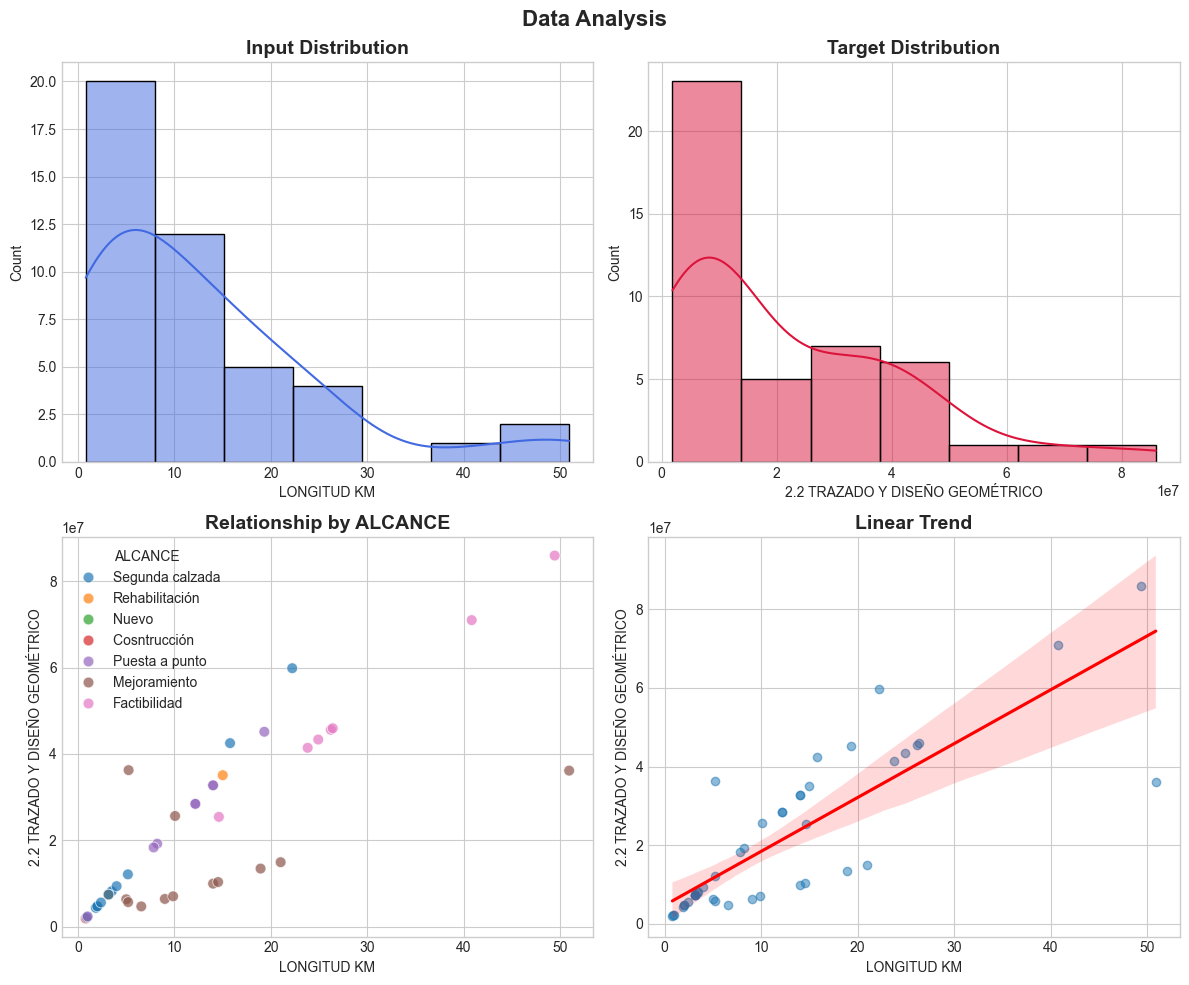

Best params: {'regressor__svr__C': 300, 'regressor__svr__epsilon': 0.1, 'regressor__svr__gamma': 0.01}
{'Test_R2': 0.9250118387998649, 'Test_MAE': 2003524.9261956662, 'Test_RMSE': 10161441633236.273, 'Test_MAPE%': 15.63099727691796}


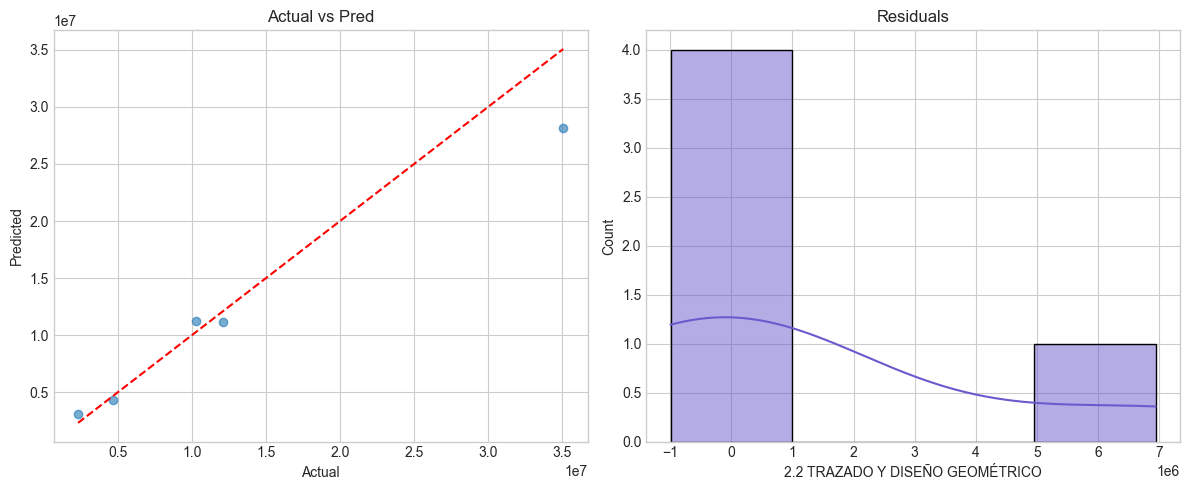

*********2.3 - SEGURIDAD VIAL*********


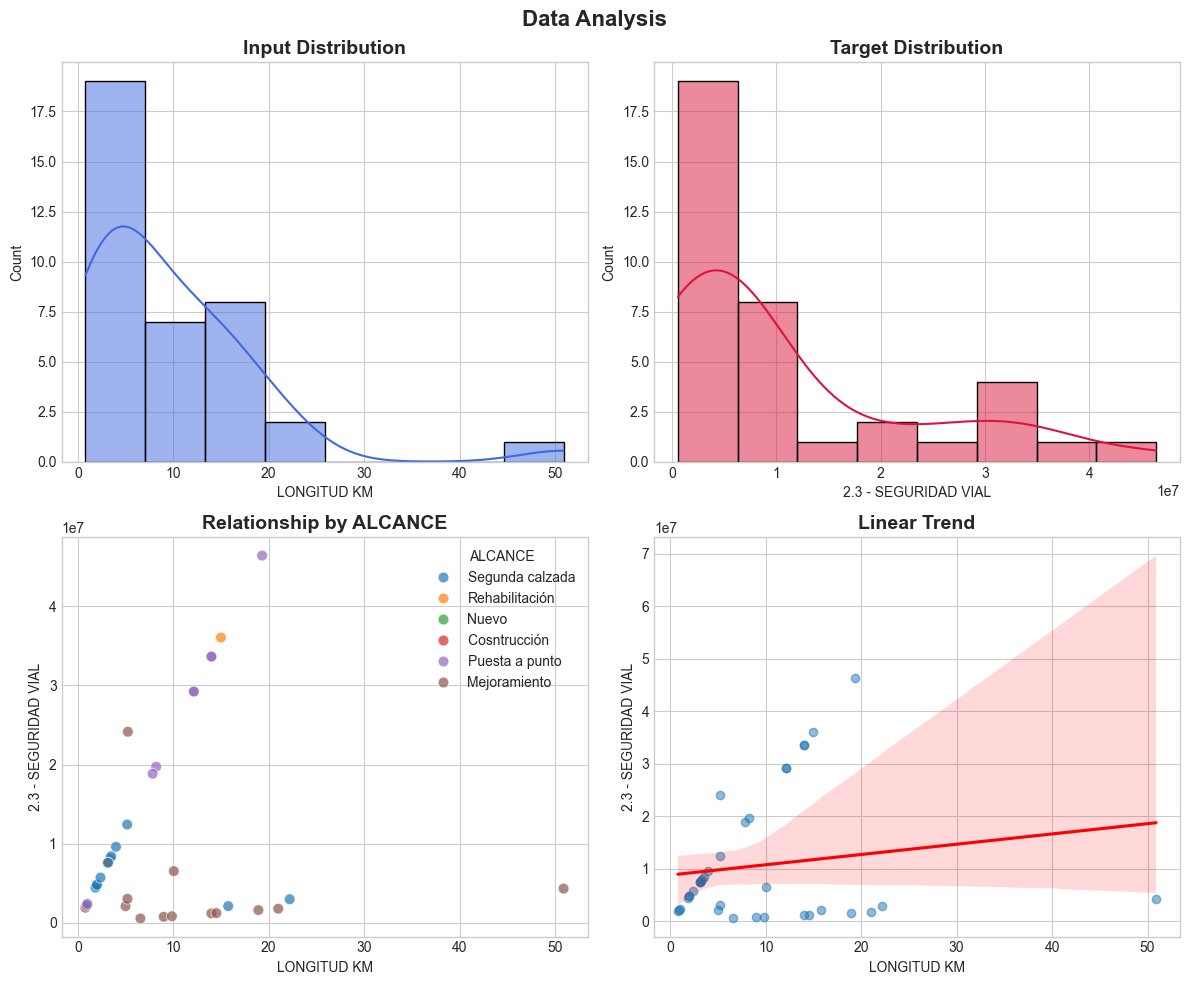

Best params: {'regressor__svr__C': 100, 'regressor__svr__epsilon': 0.1, 'regressor__svr__gamma': 'auto'}
{'Test_R2': -0.19835034818330932, 'Test_MAE': 8502786.725328488, 'Test_RMSE': 251213114270950.75, 'Test_MAPE%': 51.16924887333872}


c:\Users\forer\anaconda3\envs\practicum\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


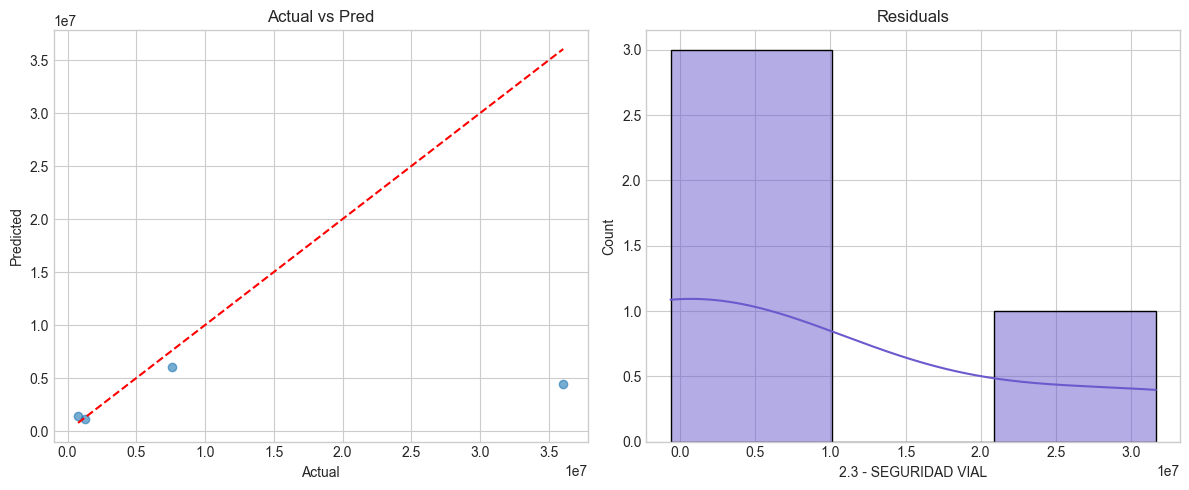

*********2.4 - SISTEMAS INTELIGENTES*********


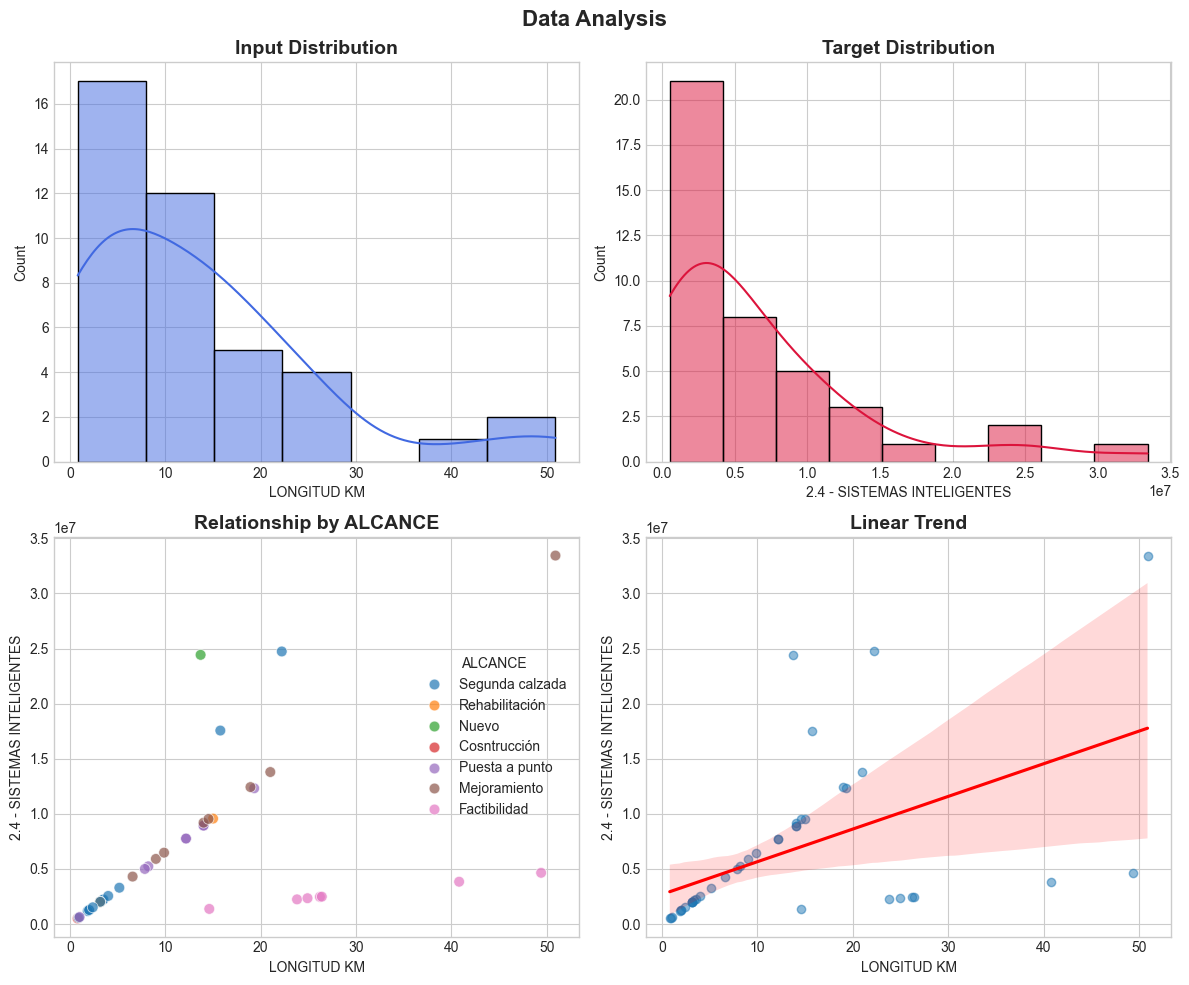

Best params: {'regressor__svr__C': 300, 'regressor__svr__epsilon': 0.1, 'regressor__svr__gamma': 0.01}
{'Test_R2': 0.8811415809168793, 'Test_MAE': 827953.2862928723, 'Test_RMSE': 1835360640956.8218, 'Test_MAPE%': 14.337508980430394}


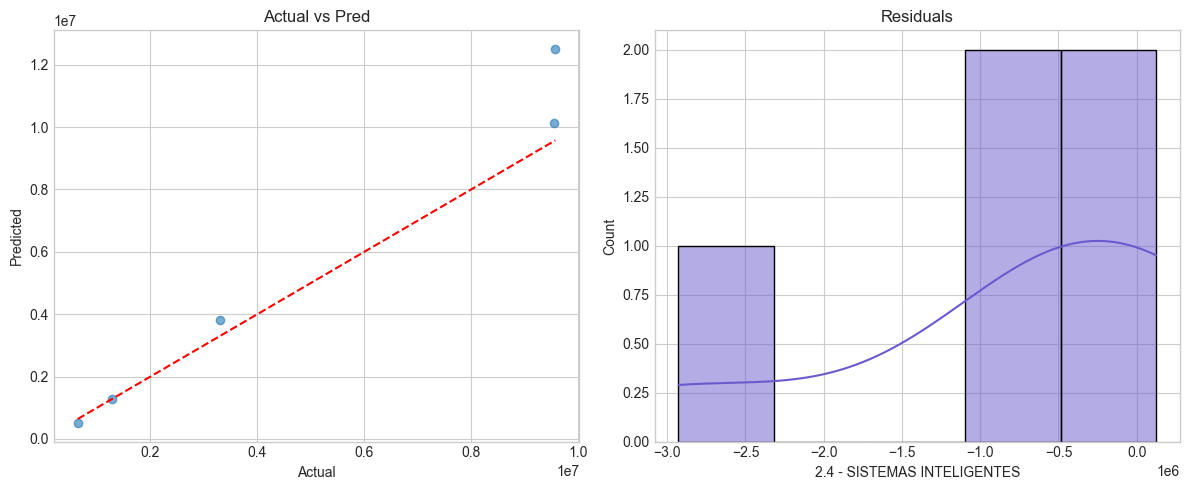

*********5 - TALUDES*********


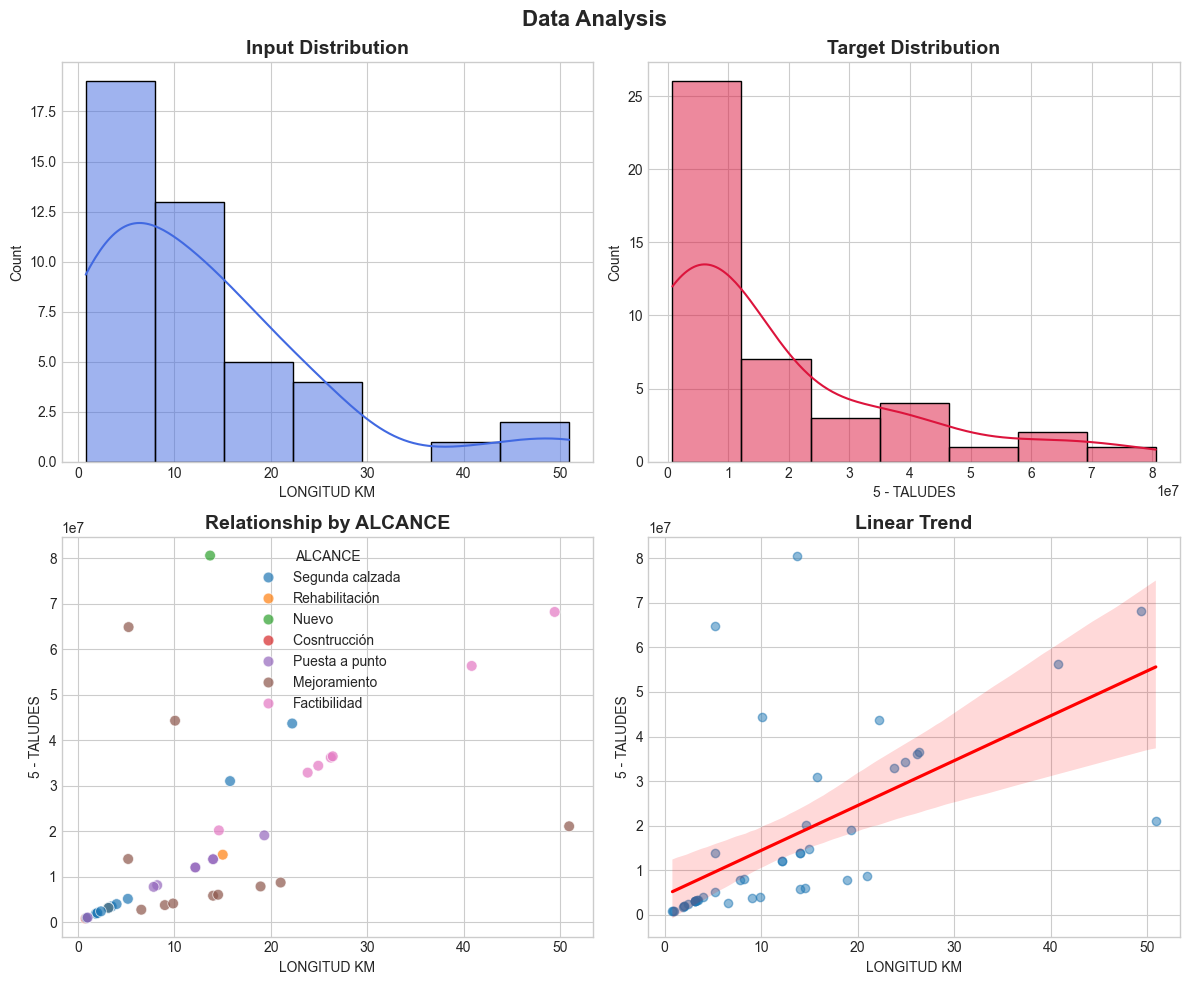

Best params: {'regressor__svr__C': 100, 'regressor__svr__epsilon': 0.1, 'regressor__svr__gamma': 0.01}
{'Test_R2': 0.920053075844096, 'Test_MAE': 920484.337888894, 'Test_RMSE': 1909762655939.444, 'Test_MAPE%': 12.185196438038512}


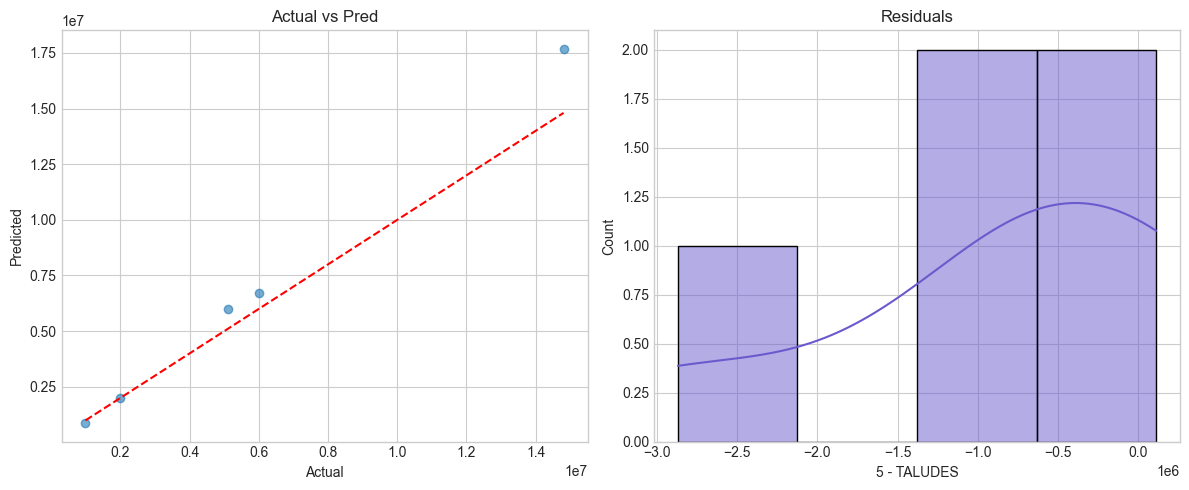

*********6 - PAVIMENTO*********


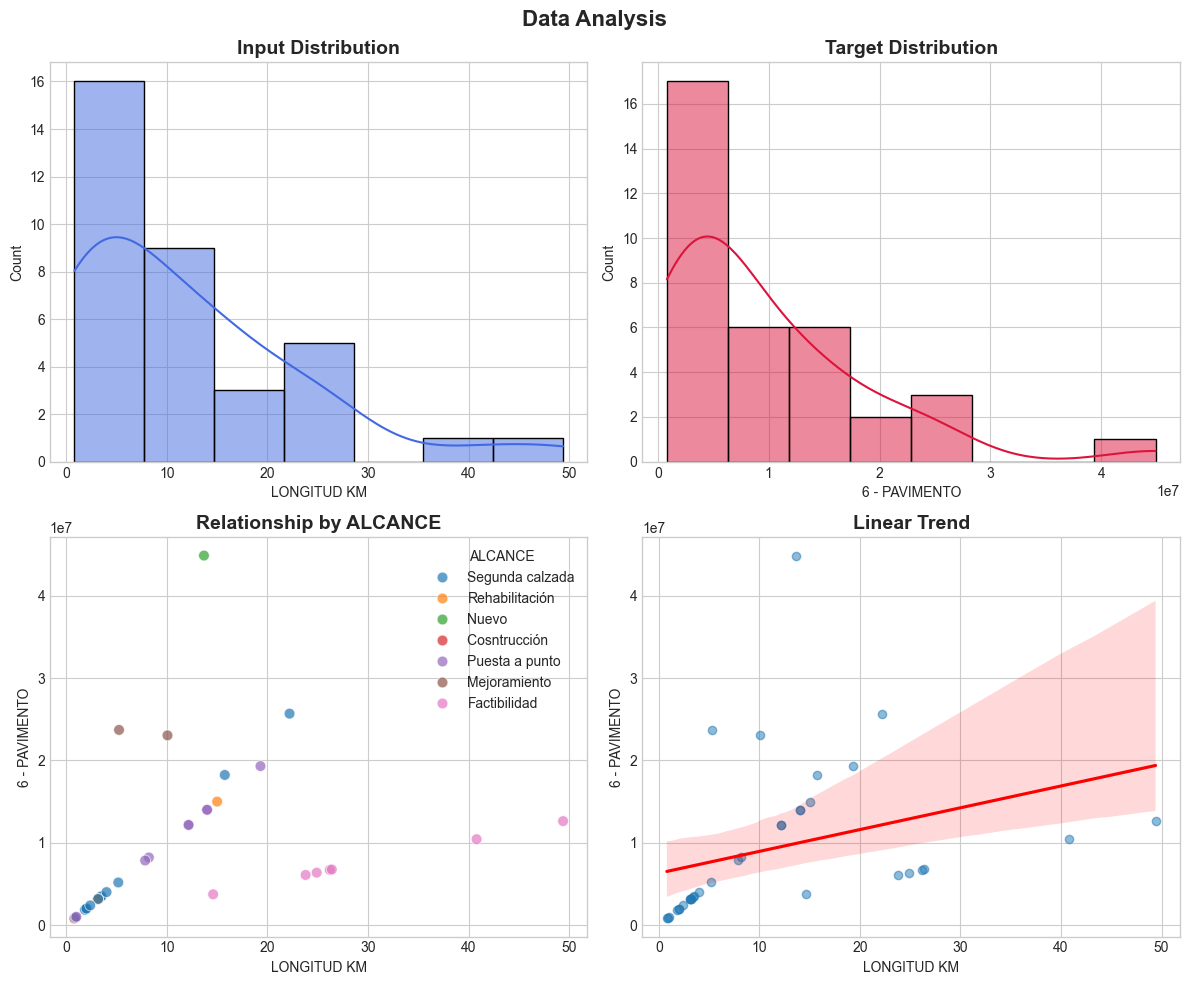

Best params: {'regressor__svr__C': 100, 'regressor__svr__epsilon': 0.1, 'regressor__svr__gamma': 0.01}
{'Test_R2': 0.9757404349430377, 'Test_MAE': 206215.69792746037, 'Test_RMSE': 58387605900.58402, 'Test_MAPE%': 6.595069799549391}


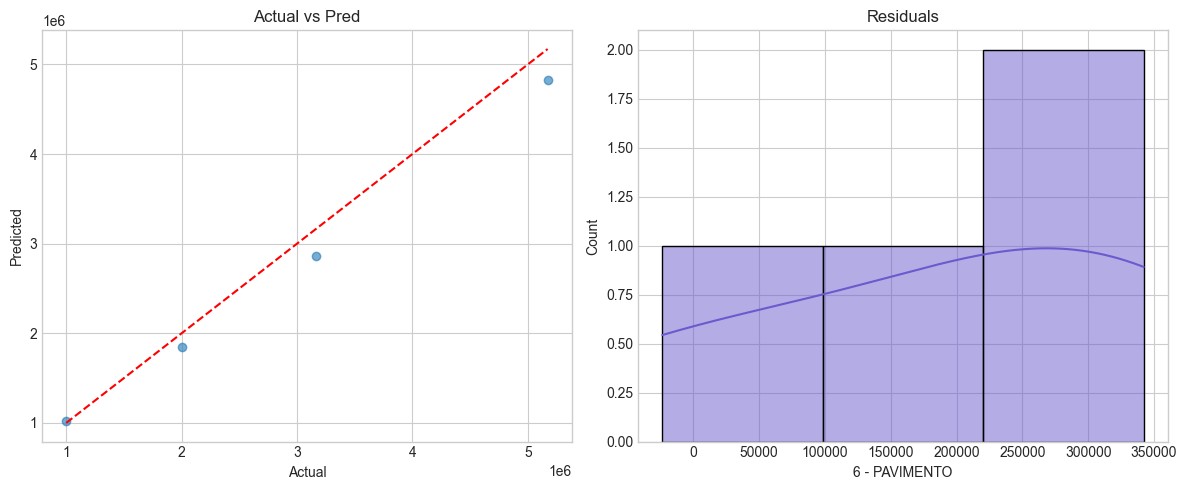

*********7 - SOCAVACIÓN*********


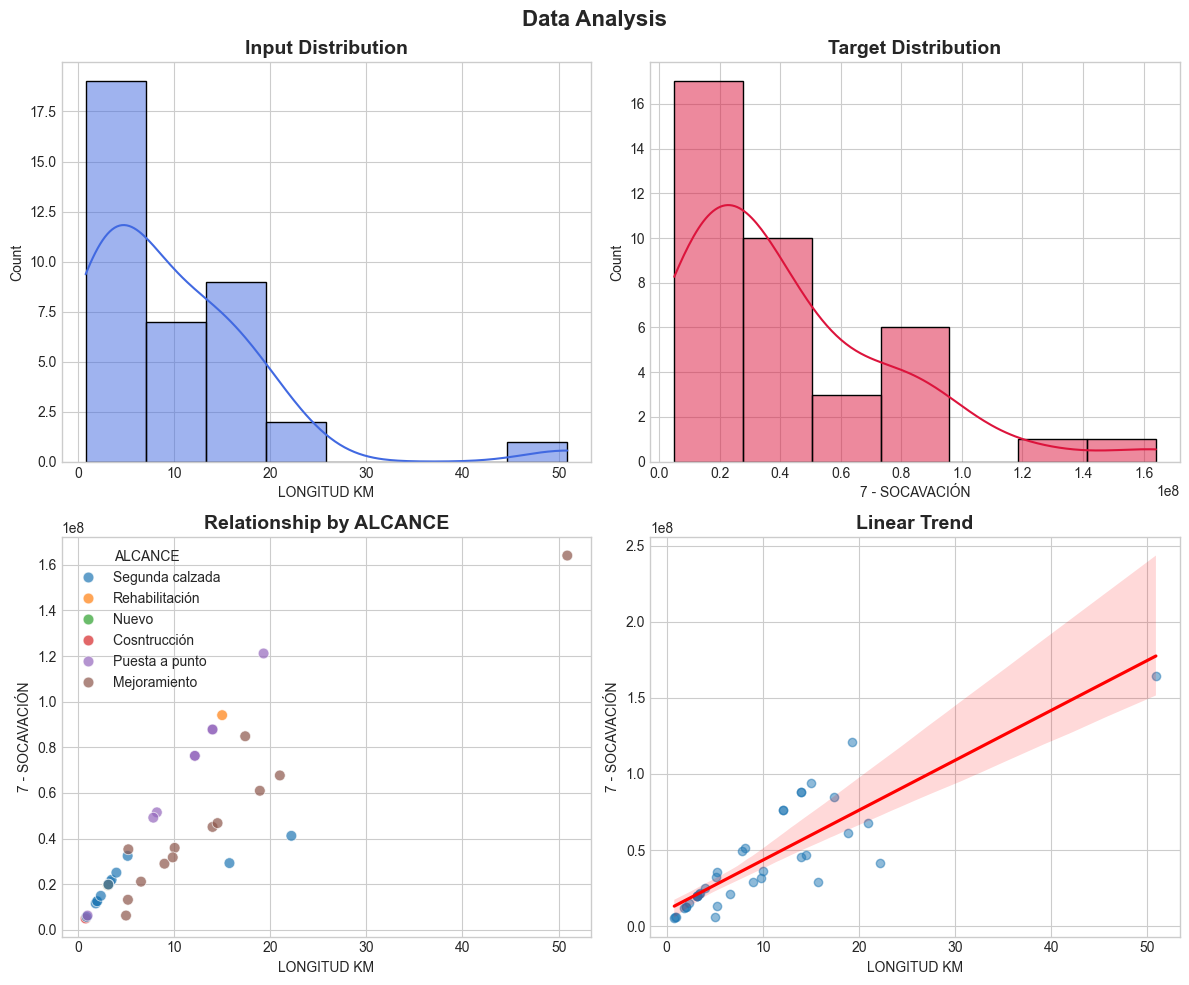

Best params: {'regressor__svr__C': 300, 'regressor__svr__epsilon': 0.1, 'regressor__svr__gamma': 0.01}
{'Test_R2': 0.8848721792300541, 'Test_MAE': 6386630.829213102, 'Test_RMSE': 85960803486586.69, 'Test_MAPE%': 10.846554374363695}


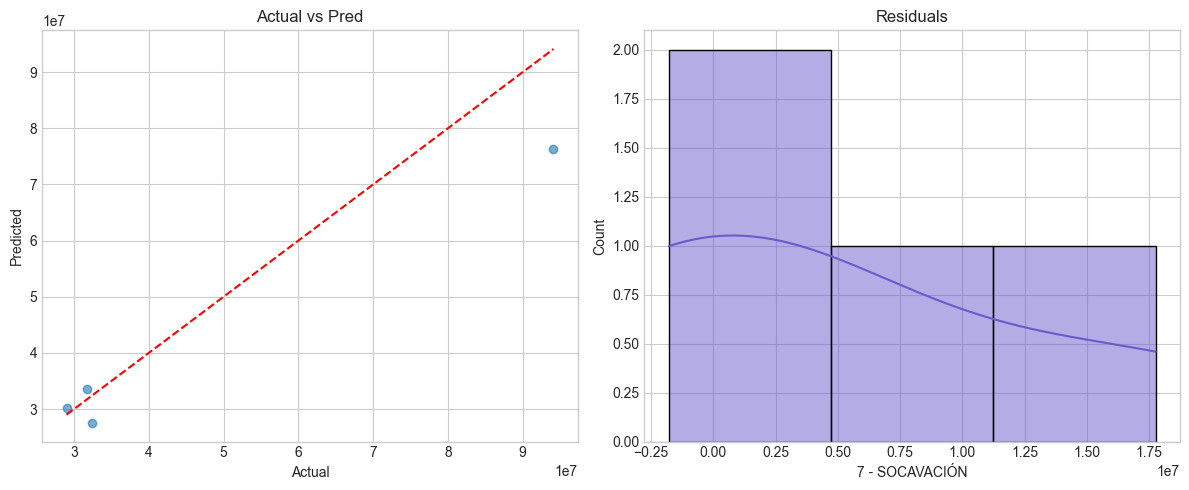

*********11 - PREDIAL*********


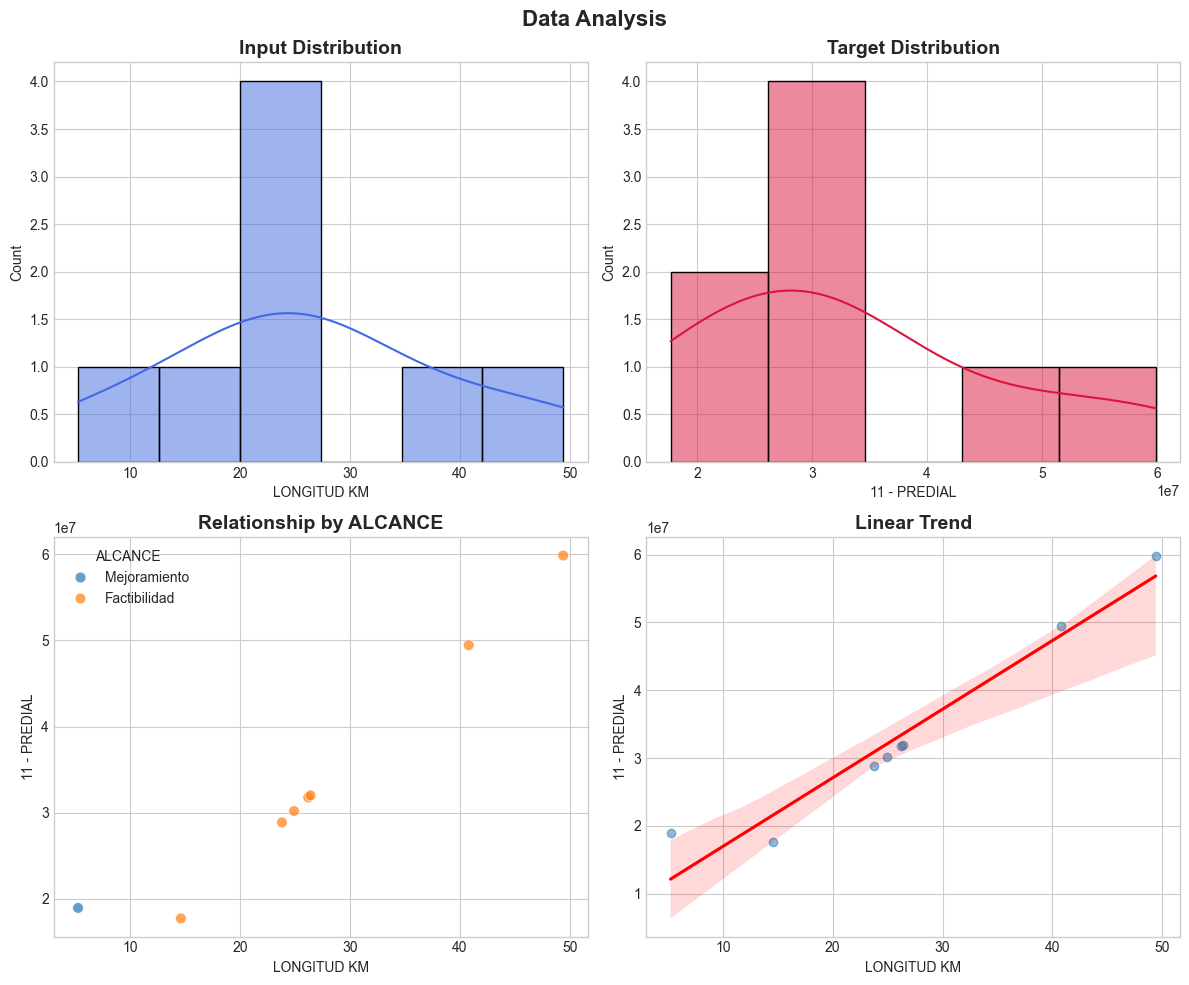

c:\Users\forer\anaconda3\envs\practicum\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Best params: {'regressor__svr__C': 10, 'regressor__svr__epsilon': 0.1, 'regressor__svr__gamma': 0.01}
{'Test_R2': nan, 'Test_MAE': 814350.4926802777, 'Test_RMSE': 663166724928.611, 'Test_MAPE%': 2.5645910694753895}


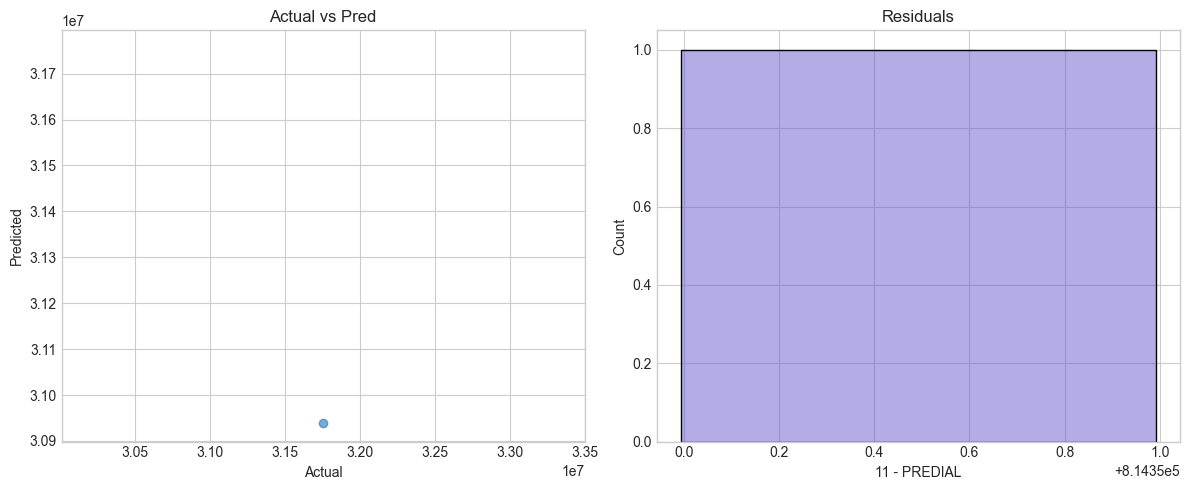

*********12 - IMPACTO AMBIENTAL*********


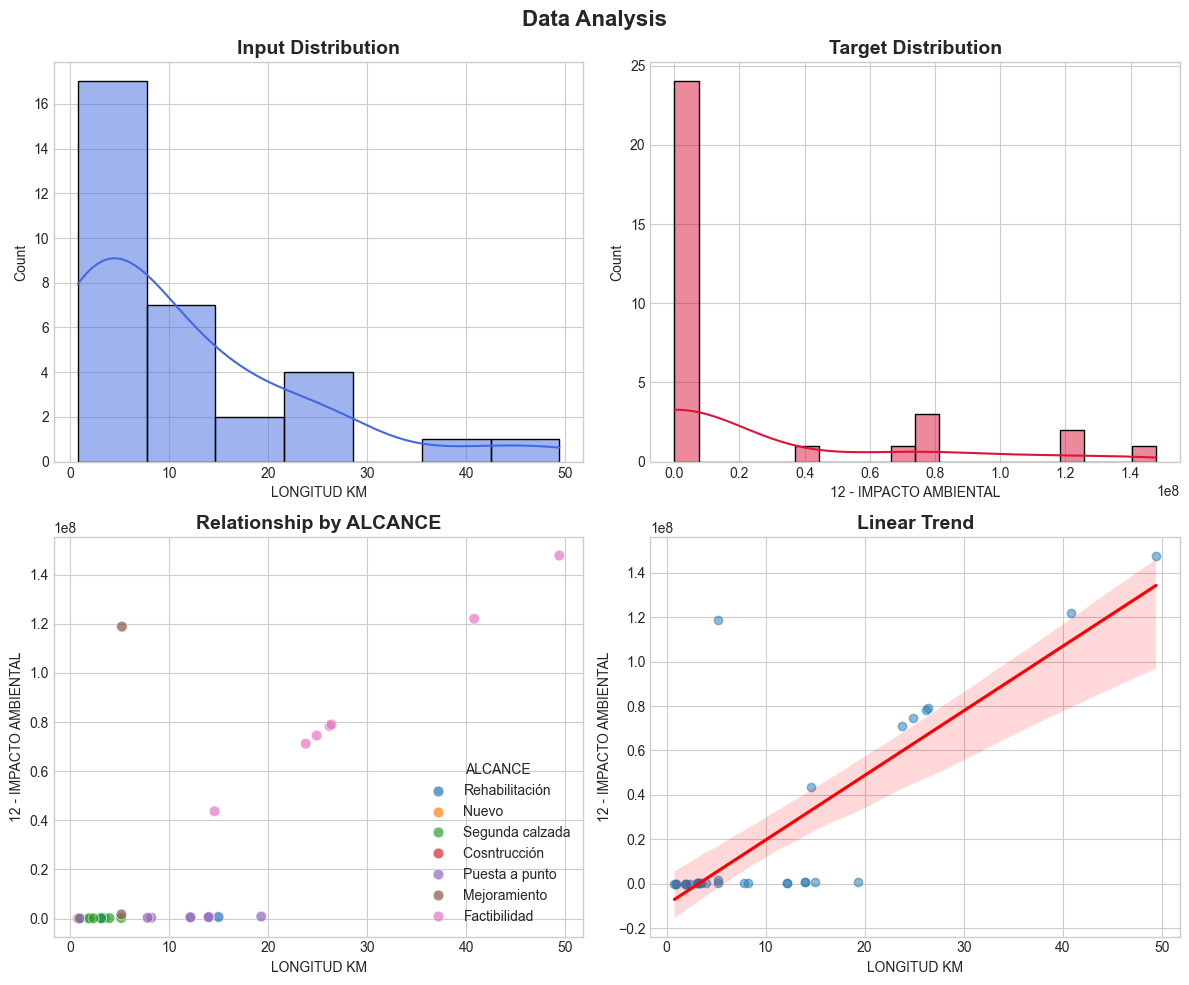

Best params: {'regressor__svr__C': 10, 'regressor__svr__epsilon': 0.1, 'regressor__svr__gamma': 0.1}
{'Test_R2': 0.9985214010779008, 'Test_MAE': 680065.8234043765, 'Test_RMSE': 1691775425409.5793, 'Test_MAPE%': 10.589558155357572}


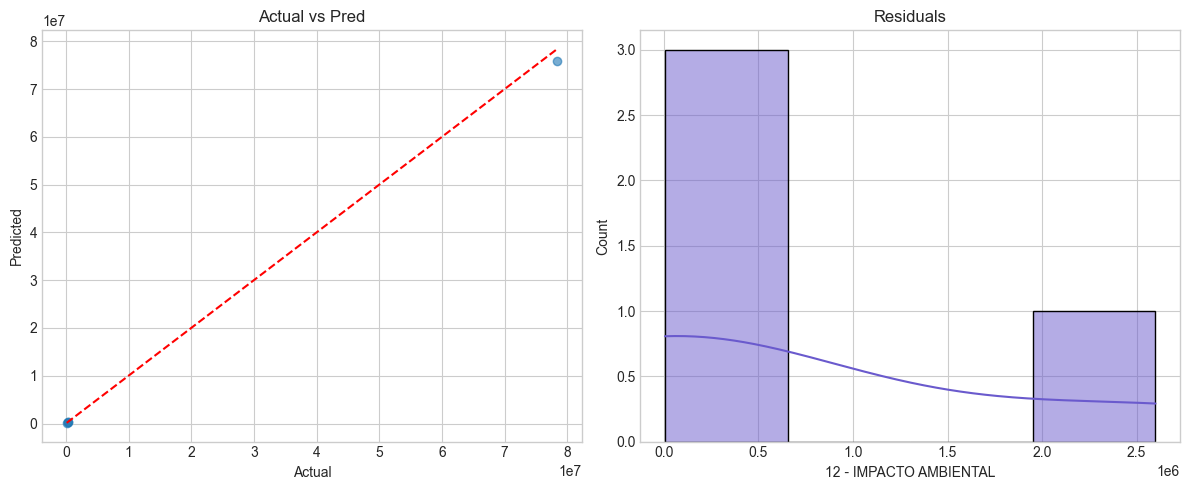

*********15 - OTROS - MANEJO DE REDES*********


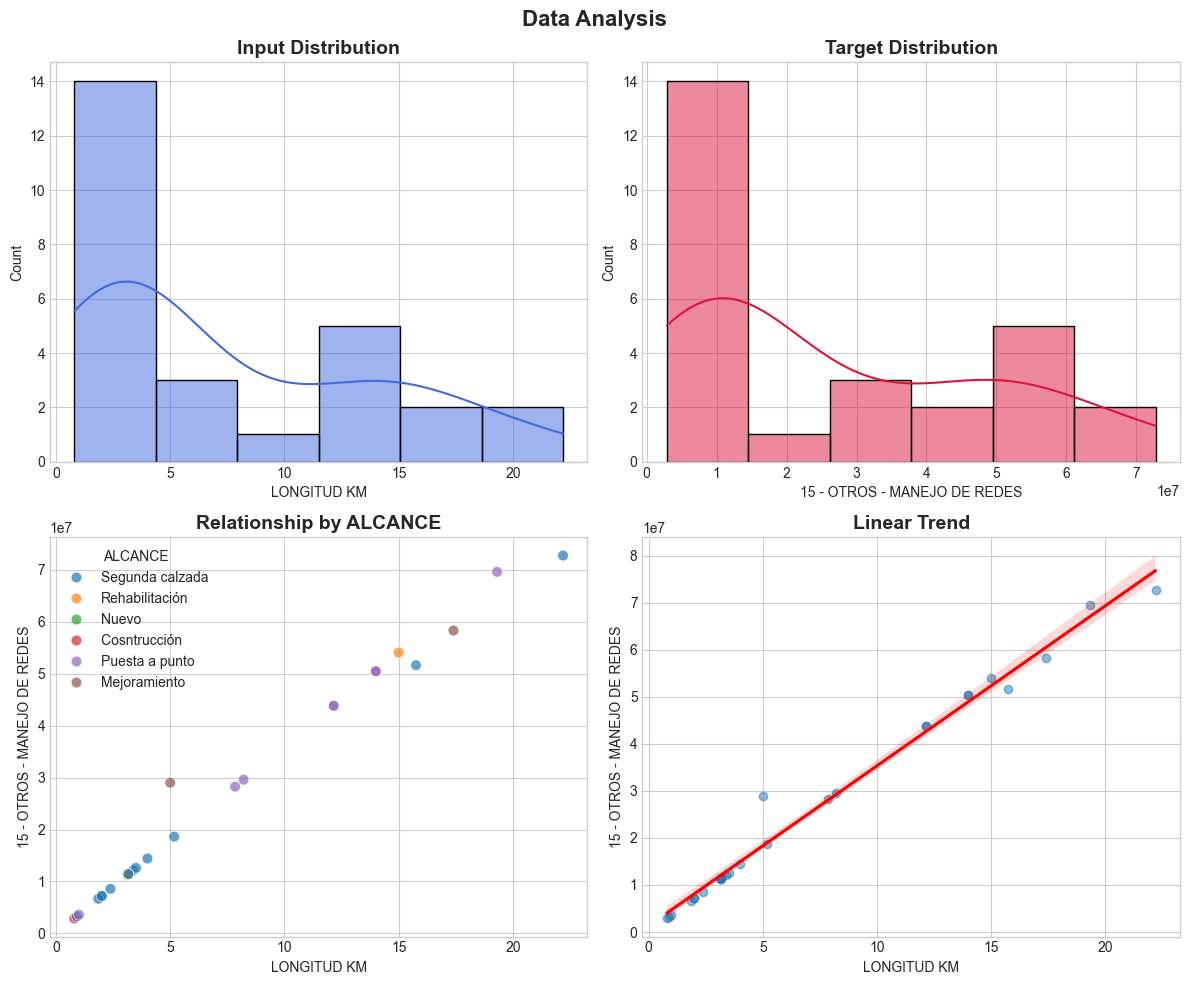

Best params: {'regressor__svr__C': 10, 'regressor__svr__epsilon': 0.1, 'regressor__svr__gamma': 0.01}
{'Test_R2': 0.8619829963551581, 'Test_MAE': 6454700.82484078, 'Test_RMSE': 85221267498320.52, 'Test_MAPE%': 25.82804668114121}


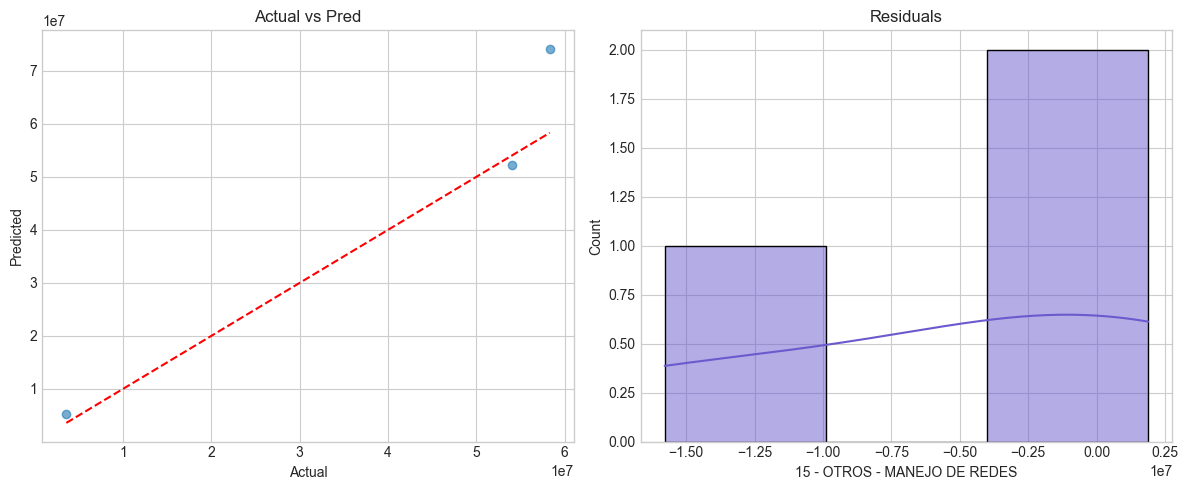

In [46]:
predictor_name = 'LONGITUD KM'
hue_name = 'ALCANCE'
target_names_function_of_longitude = ['2.2 TRAZADO Y DISEÑO GEOMÉTRICO', 
                                      '2.3 - SEGURIDAD VIAL',
                                      '2.4 - SISTEMAS INTELIGENTES', 
                                      '5 - TALUDES',
                                      '6 - PAVIMENTO',
                                      '7 - SOCAVACIÓN',
                                      '11 - PREDIAL',
                                      '12 - IMPACTO AMBIENTAL',
                                      '15 - OTROS - MANEJO DE REDES']

for target_name in target_names_function_of_longitude:
    df_item = df.loc[:, [predictor_name, hue_name, target_name]]
    df_item_cleaned = remove_outliers(df_item, target_name)
    print(f'*********{target_name}*********')
    preproccesing.show_plots_eda(predictor_name, target_name, hue_name, df_item_cleaned)
    train_model(df_item_cleaned, predictor_name, hue_name, target_name)

In [60]:
predictor_name = 'LONGITUD KM'
hue_name = 'ALCANCE'
target_names_function_of_longitude = '2.4 - SISTEMAS INTELIGENTES'
df_item = df.loc[:, [predictor_name, hue_name, target_names_function_of_longitude]]
df_clean = remove_outliers(df_item, target_names_function_of_longitude)

Best params: {'regressor__svr__C': 300, 'regressor__svr__epsilon': 0.1, 'regressor__svr__gamma': 0.01}
{'Test_R2': 0.8811415809168793, 'Test_MAE': 827953.2862928723, 'Test_RMSE': 1835360640956.8218, 'Test_MAPE%': 14.337508980430394}


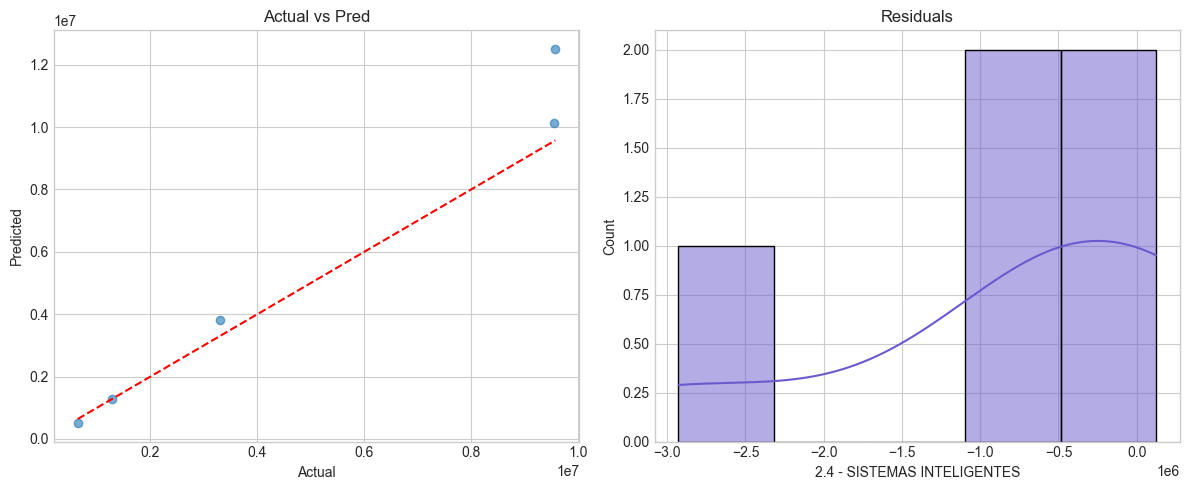

In [63]:
train_model
Xte, yte, yp  = train_model(df_clean, predictor_name, hue_name, target_names_function_of_longitude)

In [64]:
Xte['ACTUAL'] = yte
Xte['PREDICTED'] = yp
output = Xte.drop(columns=['LONGITUD KM LOG'])
output

,LONGITUD KM,ALCANCE,ACTUAL,PREDICTED
2,15.00,Rehabilitación,9.571958e+06,1.249968e+07
36,14.52,Mejoramiento,9.539932e+06,1.012079e+07
15,2.00,Segunda calzada,1.276261e+06,1.271361e+06
7,5.17,Segunda calzada,3.299135e+06,3.801650e+06
18,1.00,Puesta a punto,6.381305e+05,5.143539e+05


In [65]:
df_clean

,LONGITUD KM,ALCANCE,2.4 - SISTEMAS INTELIGENTES
0,15.76,Segunda calzada,1.756166e+07
1,22.20,Segunda calzada,2.473788e+07
2,15.00,Rehabilitación,9.571958e+06
3,3.12,Nuevo,1.990967e+06
4,3.37,Segunda calzada,2.150500e+06
5,0.80,Cosntrucción,5.105044e+05
6,3.50,Segunda calzada,2.233457e+06
7,5.17,Segunda calzada,3.299135e+06
8,19.31,Puesta a punto,1.232230e+07
9,8.21,Puesta a punto,5.239052e+06
